# SI670 Project: Boston Health Inspections

# Part 2: ML Model Building

### Planning
- Read in sampled subset of the data
- Perform some pre-processing previously not done (scaling of square footage)
- Separate data for model training and evaluation
- Machine Learning Process:
    - Baselines: Dummy classifier with strategy=[uniform, stratified, most frequent, prior
    - Vanilla ML Models: Logistic Regression, Linear SVC, KNN, Random Forest, XGBoost
    - Principal Component Analysis (PCA)
    - GridSearch parameter tuning  

# Setup
Import Pandas and, if running non-local, mount to Google Drive for file access

In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Read & Prepare a Sample as Dataframe

In [ ]:
#sample_df = pd.read_csv("sampled_clean_data.csv")
sample_df = pd.read_csv('drive/Shared drives/SI670 Project [Machine Learning]/data/sampled_clean_data_3.csv')
sample_df.drop(["Unnamed: 0"], axis=1, inplace=True)

In [ ]:
sample_df.head(5)

,licenseno,result,property_id,declared_valuation,total_fees,sq_feet,Active,Deleted,Inactive,Eating & Drinking,Eating & Drinking w/ Take Out,Mobile Food Walk On,Retail Food,FS,FT,MFW,RF,2108,2109,2110,2111,2113,2114,2115,2116,2117,2118,2119,2120,2121,2122,2124,2125,2126,2127,2128,2129,2130,2131,2132,2134,2135,2136,2140,2163,2199,2201,2203,2210,2215,2315,2467,1-2FAM,1-3FAM,1-4FAM,1-7FAM,1Unit,2unit,3unit,4unit,5unit,6unit,7More,7unit,COMM,Comm,Mixed,Multi,Other,VacLd
0,74211,1,0,2.340426,-0.114943,0.0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,28288,0,0,0.042553,0.114943,0.0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,28288,0,0,0.638298,0.114943,3000.0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,74211,0,0,0.042553,-0.233046,0.0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,28288,1,0,-0.172426,-0.189655,1000.0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [ ]:
from sklearn.preprocessing import RobustScaler
#### scaling sq_feet, since it wasn't scaled prior
scaler = RobustScaler()
scaled_sq_feet = scaler.fit_transform(sample_df.sq_feet.values.reshape(-1,1))
sample_df["sq_feet"] = scaled_sq_feet

In [ ]:
#sample_df.columns

In [ ]:
#### Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

In [ ]:
sample_df.head(3)

,licenseno,result,property_id,declared_valuation,total_fees,sq_feet,Active,Deleted,Inactive,Eating & Drinking,Eating & Drinking w/ Take Out,Mobile Food Walk On,Retail Food,FS,FT,MFW,RF,2108,2109,2110,2111,2113,2114,2115,2116,2117,2118,2119,2120,2121,2122,2124,2125,2126,2127,2128,2129,2130,2131,2132,2134,2135,2136,2140,2163,2199,2201,2203,2210,2215,2315,2467,1-2FAM,1-3FAM,1-4FAM,1-7FAM,1Unit,2unit,3unit,4unit,5unit,6unit,7More,7unit,COMM,Comm,Mixed,Multi,Other,VacLd
0,74211,1,0,2.340426,-0.114943,0.0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,28288,0,0,0.042553,0.114943,0.0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,28288,0,0,0.638298,0.114943,3000.0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#### Setup data for model training
from sklearn.model_selection import train_test_split

X = sample_df.loc[:, [i for i in sample_df.columns if i != "result"]]
y = sample_df.loc[:, "result"].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, stratify=y)

# Dummy Classifier Baseline
We run a dummy classifier under various strategies to see how generic heuristics / rules perform and to establish a baseline for how much room for improvement there might exist with machine learning approaches.

- uniform: 0.4962
- stratified: 0.5033
- most_frequent: 0.5113
- prior: 0.5113

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

#### set baseline via dummy classifier performance under varied strategies
dummy_strats = ["uniform", "stratified", "most_frequent"]
for strat in dummy_strats:
    dummy_clf = DummyClassifier(strategy=strat).fit(X_train, y_train.ravel())
    print(f"{strat}: {round(dummy_clf.score(X_test, y_test.ravel()),4)}")

uniform: 0.4945
stratified: 0.5007
most_frequent: 0.5113


# Vanilla ML Models
Creating vanilla ML Models (default hyperparameters) to gauge performance on our data. There was also no additional pre-processing necessary for our data other than scaling and a stratified test-train split.

Vanilla ML model accuracy:

- Logistic Regression: 0.4906
- Linear SVC: 0.5103
- K-Nearest Neighbors: 0.5668
- Random Forest: 0.546
- XGBoost Classifier: 0.5765

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#### Testing base accuracy for models under default params and no PCA
vanilla_models = {
    'logisticRegressor': LogisticRegression(),
    'linearSVC': LinearSVC(),
    'KNearest': KNeighborsClassifier(),
    'RandForest': RandomForestClassifier(),
    'XGBoost': XGBClassifier()
    }

for i in vanilla_models.items():
    clf = i[1].fit(X_train, y_train.ravel())
    print(f"{i[0]}: {round(clf.score(X_test, y_test.ravel()),6)}")

logisticRegressor: 0.498518
linearSVC: 0.490614
KNearest: 0.563179
RandForest: 0.5477
XGBoost: 0.57284


# Principal Component Analysis (PCA)
We chose to use principal component analysis to explore to what extent usage of principal components could be effective at improving the performance of our models, both in terms of accuracy and runtime, especially given our having sixty-nine non-label features being included in our data.

## Testing Models @N Principal Components

In [ ]:
#### Principal Component Analysis (PCA)
from sklearn.decomposition import PCA

N = 3
pca = PCA(n_components=N)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
# pca.explained_variance_

#### Testing base accuracy for models under default params and no PCA
vanilla_models_PCA = {
    'logisticRegressor': LogisticRegression(),
    'linearSVC': LinearSVC(),
    'KNearest': KNeighborsClassifier(),
    'RandForest': RandomForestClassifier(),
    'XGBoost': XGBClassifier()
    }

print(f"Vanilla Models under PCA [{N} Components]")
for i in vanilla_models_PCA.items():
    clf = i[1].fit(X_train_pca, y_train.ravel())
    print(f"\t{i[0]}: {round(clf.score(X_test_pca, y_test.ravel()),6)}")

Vanilla Models under PCA [3 Components]
	logisticRegressor: 0.525854
	linearSVC: 0.524317
	KNearest: 0.561313
	RandForest: 0.586453
	XGBoost: 0.580744


## Variable number of PCA components
It seems that the best performance comes from KNN and RF at 3 components and, secondarily, KNN/XGB at 6. KNN has marginal enough improvement at 6 versus 3 that it seems to be equivalent or noise-differentiated rather than meaningful difference, but XGB is a full percent lower at 6 component than KNN and RF appear to be at 3 components, so focus falls on three component configuration.

In [ ]:
#### Principal Component Analysis (PCA)
pca_scores = {}

#### Best seems to be KNN/RF at 3
#### Second best seems to be KNN/XGB at 6
for i in range(1, 10):
    pca = PCA(n_components=i)

    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    # pca.explained_variance_
    
    #c = XGBClassifier()
    #c = KNeighborsClassifier()
    c = RandomForestClassifier()
    c.fit(X_train_pca, y_train.ravel())
    
    pca_scores[i] = c.score(X_test_pca, y_test.ravel())
    

In [ ]:
pca_scores

{1: 0.5831595125699858,
 2: 0.5855747063343946,
 3: 0.5864529586123614,
 4: 0.5528598089801295,
 5: 0.561642331759798,
 6: 0.569217257657262,
 7: 0.5695466022614997,
 8: 0.5731693929081129,
 9: 0.5707541991437041}

# GridSearch Parameter Tuning
We are taking the best-performing models thusfar and checking to see if, with and without principal components, we are able to "squeeze out" any further performance.

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV

#### Setup Proper PCA Count
N = 3

if(N==0):
    print("PCA Set to Zero, Default Data Being Used")
    X_train_pca = X_train
    X_test_pca = X_test
else:
    pca = PCA(n_components=N)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

## K-Nearest Neighbors Grid Search Tuning
NonPCA: acc=0.5719 for <code>{'algorithm': 'kd_tree', 'n_neighbors': 100, 'weights': 'uniform'}</code><br/>
PCA@3: acc=0.5761 for <code>{'algorithm': 'kd_tree', 'n_neighbors': 100, 'weights': 'uniform'}</code><br/>
Alright then, seems the verdict is that the same parameters hold with or without PCA at 3 components.

In [ ]:
#### KNeighbors Parameter Tuning
# Best at PCA = 3
clf_knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors': [5, 50, 100, 150],
    'weights': ["uniform", "distance"],
    'algorithm': ["ball_tree", "kd_tree"]
    }

cv_knn = GridSearchCV(clf_knn, param_grid, scoring="accuracy")
cv_knn.fit(X_train_pca, y_train.ravel())
print(f"Given {N} principal components")
print(f"Grid-Best Score: {round(cv_knn.best_score_,4)}")
print(f"Grid-Best Parameters: {cv_knn.best_params_}")

#### Pass best parameters to a classifier and check score
tuned_KNN = KNeighborsClassifier(**cv_knn.best_params_)
tuned_KNN.fit(X_train_pca, y_train.ravel())
print(tuned_KNN.score(X_test_pca, y_test.ravel()))

Given 0 principal components
Grid-Best Score: 0.5794
Grid-Best Parameters: {'algorithm': 'kd_tree', 'n_neighbors': 100, 'weights': 'uniform'}


0.5719617960259085

## Random Forest Grid Search Tuning
NonPCA: <code>acc=0.5705</code> for <code>{'max_features': None, 'min_samples_split': 6, 'n_estimators': 200}</code><br/>
PCA@3: <code>acc=0.5875</code> for <code>{'max_features': None, 'min_samples_split': 6, 'n_estimators': 200}</code><br/>
This takes a solid 50 minutes running raw, 20 minutes running @PCA=3. That note aside, similar to KNN, same ideal parameter sets here and it seems like Random Forest with three principal components gives us our best performance.

In [ ]:
#### RandomForest Parameter Tuning
# Best at PCA = 3
from datetime import datetime
start = datetime.now()

clf_rf = RandomForestClassifier()
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ["auto", "log2", None],
    'min_samples_split': [2, 4, 6],
    }

cv_rf = GridSearchCV(clf_rf, param_grid, scoring="accuracy")
cv_rf.fit(X_train_pca, y_train.ravel())
print(f"Grid-Best Score: {round(cv_rf.best_score_,4)}")
print(f"Grid-Best Parameters: {cv_rf.best_params_}")

#### Pass best parameters to a classifier and check score
tuned_RF = RandomForestClassifier(**cv_rf.best_params_)
tuned_RF.fit(X_train_pca, y_train.ravel())
print(tuned_RF.score(X_test_pca, y_test.ravel()))

stop = datetime.now()
print(stop-start)

Grid-Best Score: 0.5875
Grid-Best Parameters: {'max_features': None, 'min_samples_split': 6, 'n_estimators': 200}
0.5878801185640575
0:20:10.049381


## XGBoost Tuning
Best Parameters: <code>colsample_bytree=0.5, learning_rate=0.01, max_depth=10, min_child_weight=5, n_estimators=400, objective="reg:squarederror", subsample=0.7</code><br/><br/>
Accuracy: a pretty stable 0.595 if you round to the third place, seems to be best-performing model, but needs to be run with six principal components.

In [ ]:
#### KNeighbors Parameter Tuning
# Best at PCA = 6
clf_xgb = XGBClassifier()
param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.7],
    'colsample_bytree': [0.5, 0.7],
    'n_estimators' : [100, 200, 400],
    'objective': ['reg:squarederror', 'binary:logistic']
}   

cv_xgb = GridSearchCV(clf_xgb, param_grid, scoring="accuracy")
cv_xgb.fit(X_train_pca, y_train.ravel())
print(f"Given {N} principal components")
print(f"Grid-Best Score: {round(cv_xgb.best_score_,4)}")
print(f"Grid-Best Parameters: {cv_xgb.best_params_}")

#### Pass best parameters to a classifier and check score
tuned_KNN = KNeighborsClassifier(**cv_xgb.best_params_)
tuned_KNN.fit(X_train_pca, y_train.ravel())
print(tuned_KNN.score(X_test_pca, y_test.ravel()))

# Final Model
Our final model is an XGBoost that takes in a six-principal-component tranform of the data and seems generally stable at achieving 60% accuracy or higher when trained on the larges (82mb) sample.

In [ ]:
pca = PCA(n_components=6)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
clf_XGB = XGBClassifier(colsample_bytree=0.5, learning_rate=0.01, max_depth=10, min_child_weight=5,
                       n_estimators=400, objective="reg:squarederror", subsample=0.7)
clf_XGB.fit(X_train_pca, y_train.ravel())
clf_XGB.score(X_test_pca, y_test.ravel())

0.6063370771713712

In [ ]:
important_feet = clf_XGB.feature_importances_
print(important_feet)

[0.16490306 0.29846537 0.30236718 0.05136454 0.05271646 0.13018347]


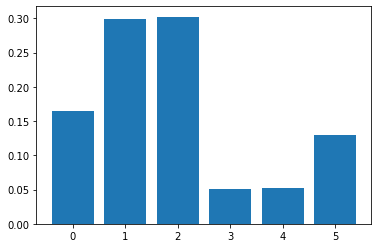

In [ ]:
#### Let's see how important these components are
from matplotlib import pyplot
pyplot.bar([x for x in range(len(important_feet))], important_feet)
pyplot.show()